# Project - addition

Simple dense layer neural net to compute addition of 2 numbers x1, x2 between 0 and 100 and output answer in one-hot vector, Y

The problem boils down to using a dense layer neural net to convert a single integer into a one-hot vector.
Theoretically, there is a explicit solution to this:

Let Z1 be the integer which ranges between 0 and 199 which has to be converted into one-hot
Let Z2 be a vector derived by multiplying Z1 by [1/0.0001, 1/1, 1/2, 1/3, 1/4 ... 1/198] and following by subtracting 1 from result.
Apply activation function -Abs(Z2) to obtain a vector where maximum value is found at the corresponding positon with 1 value of the one-hot vector. 
Set maximum value to 1 and rest zero.

Attempt was made to build model with 2 hidden layers and input layer of 2 nodes:
(1) first hidden layer comprises of one node, holding the sum of x1 and x2 (Z1)
(2) second 199-node hidden layer computes Z2 and custom activation of Z2 described above
(3) 199-node output layer uses sigmoid or softmax activation

However, model was unable to converge without performing kernal initialization. 

Alternative model of single 200-node dense hidden layer with 2 concatenated one-hot vectors as input was built. This model was able to attain 100% train accuracy but only around 59% test accuracy with train data being 80% random samples from universe of all possible inputs and test being the remaining 20%.



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import keras
from keras.models import Model, Sequential
from keras.layers import *
from keras.optimizers import Adam

import tensorflow as tf
import numpy as np

import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split

print(keras.__version__)
print(tf.__version__)

Using TensorFlow backend.


2.0.8
1.3.0


# Generate dataset

In [2]:
import random
# input ranges from 0 to 99 > 100 possibilities, output from 0 to 198 > 199 possibilities
Nin = 100
Nin2 = Nin * Nin
Nout = 199

r = np.arange(Nin)
print("r:")
print(type(r), r.shape)
print(r)
print("----------------------------")

x = np.ones((Nin2,2))
y = np.ones((Nin2,1))

for i in range(Nin):
    for j in range(Nin):
        x[i*Nin+j,0] = i
        x[i*Nin+j,1] = j
        y[i*Nin+j] = i+j
print("x:")
print(type(x), x.shape)

n = random.randint(0, Nin2)
print("Printing random sample",n)
print(x[n,:])
print(y[n])
print("----------------------------")

x1_all = keras.utils.to_categorical(x[:,0], Nin)
x2_all = keras.utils.to_categorical(x[:,1], Nin)
x_all = np.append(x1_all, x2_all, axis=1)
y_all = keras.utils.to_categorical(y, Nout)

print("check x_all:")
print("x1_all:",type(x1_all), x1_all.shape)
print("x2_all:",type(x2_all), x2_all.shape)
print("x_all:",type(x_all), x_all.shape)
print(x_all[0,:])
print(x_all[1,:])
print(x_all[100,:])
print("----------------------------")

print("check x_all, y_all:")
print("Printing random sample",n)
print("x_all[",n,",:]")
print(x_all[n,:])
print("y_all[",n,"]")
print(y_all[n])

print("----------------------------")
print("Shapes :")
print("x_all :", x_all.shape)
print("y_all :", y_all.shape)



r:
<class 'numpy.ndarray'> (100,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99]
----------------------------
x:
<class 'numpy.ndarray'> (10000, 2)
Printing random sample 8963
[ 89.  63.]
[ 152.]
----------------------------
check x_all:
x1_all: <class 'numpy.ndarray'> (10000, 100)
x2_all: <class 'numpy.ndarray'> (10000, 100)
x_all: <class 'numpy.ndarray'> (10000, 200)
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0. 

# Shuffle and apportion train and test dataset

In [3]:
# randomly select 8000 samples for train and 2000 samples for test data set
random_samples = np.arange(Nin2)
print(random_samples[0:5])
#np.random.shuffle(random_samples)
np.random.shuffle(random_samples[:8000])
np.random.shuffle(random_samples[8000:])
train_samples = random_samples[:8000]
test_samples = random_samples[8000:]
print("train samples shape:", train_samples.shape)
print("train samples first 5 elements:", train_samples[0:5])

x_train = x_all[train_samples]
y_train = y_all[train_samples]
x_test = x_all[test_samples]
y_test = y_all[test_samples]
print("x_train, y_train shape:", x_train.shape, y_train.shape)
print("x_test, y_test shape:", x_test.shape, y_test.shape)

# change all inputs to float type
x_train = x_train.astype(float)
x_test = x_test.astype(float)
y_train = y_train.astype(float)
y_test = y_test.astype(float)


[0 1 2 3 4]
train samples shape: (8000,)
train samples first 5 elements: [7000 3063 5802 6793 4812]
x_train, y_train shape: (8000, 200) (8000, 199)
x_test, y_test shape: (2000, 200) (2000, 199)


# Model definition

In [4]:
# Training Parameters
n_classes = Nout
learning_rate = 0.3
training_epochs = 200
batch_size = 10

# Network
Inp = Input(shape=(x_train.shape[1],))
x = Dense(200, activation="relu", name = "Dense_1")(Inp)
output = Dense(Nout, activation="sigmoid", name = "Outputlayer")(x)


model = Model(Inp, output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
Dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
Outputlayer (Dense)          (None, 199)               39999     
Total params: 80,199
Trainable params: 80,199
Non-trainable params: 0
_________________________________________________________________


# Compile and run

In [5]:
model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])


In [6]:
K.set_value(model.optimizer.lr, learning_rate)

In [7]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=training_epochs,
                    verbose=1, # This is for what we want it to display out as it trains 
                    validation_data=(x_test, y_test))

Train on 8000 samples, validate on 2000 samples
Epoch 1/200
8000/8000 [==============================] - 1s - loss: 5.1351 - acc: 0.0069 - val_loss: 5.7106 - val_acc: 0.0045
Epoch 2/200
8000/8000 [==============================] - 1s - loss: 5.0172 - acc: 0.0084 - val_loss: 5.7873 - val_acc: 0.0035
Epoch 3/200
8000/8000 [==============================] - 1s - loss: 4.9550 - acc: 0.0091 - val_loss: 5.7732 - val_acc: 0.0015
Epoch 4/200
8000/8000 [==============================] - 1s - loss: 4.7865 - acc: 0.0105 - val_loss: 5.9225 - val_acc: 0.0010
Epoch 5/200
8000/8000 [==============================] - 1s - loss: 4.4797 - acc: 0.0120 - val_loss: 6.6583 - val_acc: 0.0000e+00
Epoch 6/200
8000/8000 [==============================] - 1s - loss: 4.1994 - acc: 0.0199 - val_loss: 7.6580 - val_acc: 0.0000e+00
Epoch 7/200
8000/8000 [==============================] - 1s - loss: 4.0114 - acc: 0.0223 - val_loss: 8.7884 - val_acc: 0.0000e+00
Epoch 8/200
8000/8000 [==============================] - 1

8000/8000 [==============================] - 1s - loss: 0.0293 - acc: 0.9956 - val_loss: 13.4864 - val_acc: 5.0000e-04
Epoch 64/200
8000/8000 [==============================] - 1s - loss: 0.0269 - acc: 0.9964 - val_loss: 13.5585 - val_acc: 0.0000e+00
Epoch 65/200
8000/8000 [==============================] - 1s - loss: 0.0228 - acc: 0.9977 - val_loss: 13.5466 - val_acc: 0.0000e+00
Epoch 66/200
8000/8000 [==============================] - 1s - loss: 0.0212 - acc: 0.9977 - val_loss: 13.6369 - val_acc: 0.0000e+00
Epoch 67/200
8000/8000 [==============================] - 1s - loss: 0.0180 - acc: 0.9982 - val_loss: 13.7347 - val_acc: 0.0000e+00
Epoch 68/200
8000/8000 [==============================] - 1s - loss: 0.0171 - acc: 0.9984 - val_loss: 13.7424 - val_acc: 0.0000e+00
Epoch 69/200
8000/8000 [==============================] - 1s - loss: 0.0156 - acc: 0.9986 - val_loss: 13.7859 - val_acc: 0.0000e+00
Epoch 70/200
8000/8000 [==============================] - 1s - loss: 0.0136 - acc: 0.9994

8000/8000 [==============================] - 1s - loss: 0.0030 - acc: 1.0000 - val_loss: 14.6839 - val_acc: 0.0000e+00
Epoch 125/200
8000/8000 [==============================] - 1s - loss: 0.0030 - acc: 1.0000 - val_loss: 14.6869 - val_acc: 0.0000e+00
Epoch 126/200
8000/8000 [==============================] - 1s - loss: 0.0030 - acc: 1.0000 - val_loss: 14.6905 - val_acc: 0.0000e+00
Epoch 127/200
8000/8000 [==============================] - 1s - loss: 0.0029 - acc: 1.0000 - val_loss: 14.6966 - val_acc: 0.0000e+00
Epoch 128/200
8000/8000 [==============================] - 1s - loss: 0.0029 - acc: 1.0000 - val_loss: 14.6999 - val_acc: 0.0000e+00
Epoch 129/200
8000/8000 [==============================] - 1s - loss: 0.0029 - acc: 1.0000 - val_loss: 14.7048 - val_acc: 0.0000e+00
Epoch 130/200
8000/8000 [==============================] - 1s - loss: 0.0028 - acc: 1.0000 - val_loss: 14.7096 - val_acc: 0.0000e+00
Epoch 131/200
8000/8000 [==============================] - 1s - loss: 0.0028 - acc:

8000/8000 [==============================] - 1s - loss: 0.0017 - acc: 1.0000 - val_loss: 14.9046 - val_acc: 0.0000e+00
Epoch 186/200
8000/8000 [==============================] - 1s - loss: 0.0017 - acc: 1.0000 - val_loss: 14.9084 - val_acc: 0.0000e+00
Epoch 187/200
8000/8000 [==============================] - 1s - loss: 0.0016 - acc: 1.0000 - val_loss: 14.9110 - val_acc: 0.0000e+00
Epoch 188/200
8000/8000 [==============================] - 1s - loss: 0.0016 - acc: 1.0000 - val_loss: 14.9140 - val_acc: 0.0000e+00
Epoch 189/200
8000/8000 [==============================] - 1s - loss: 0.0016 - acc: 1.0000 - val_loss: 14.9153 - val_acc: 0.0000e+00
Epoch 190/200
8000/8000 [==============================] - 1s - loss: 0.0016 - acc: 1.0000 - val_loss: 14.9180 - val_acc: 0.0000e+00
Epoch 191/200
8000/8000 [==============================] - 1s - loss: 0.0016 - acc: 1.0000 - val_loss: 14.9177 - val_acc: 0.0000e+00
Epoch 192/200
8000/8000 [==============================] - 1s - loss: 0.0016 - acc:

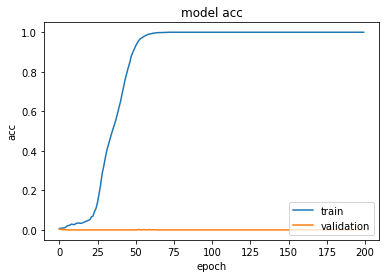

In [8]:
def plot_train(hist):
    h = hist.history
    if 'acc' in h:
        meas='acc'
        loc='lower right'
    else:
        meas='loss'
        loc='upper right'
    plt.plot(hist.history[meas])
    plt.plot(hist.history['val_'+meas])
    plt.title('model '+meas)
    plt.ylabel(meas)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc=loc)

plot_train(history)

# Train set with 20% contiguous input space omitted
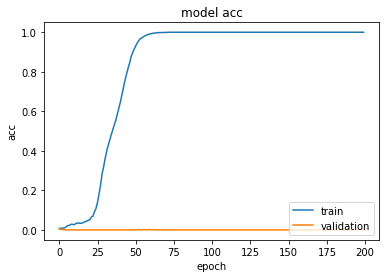
1 Hidden Layer of 200 nodes, relu activation
learning_rate = 0.3
training_epochs = 200
batch_size = 10
Trained on first 80% of ordered dataset of all complete possible datapoints
Tested/validated on last 20% or ordered dataset
Observation : Train accuracy 100% validation accuracy 0%. Model overfitted train set and gathered no useful generalisation to predict test set.


# Train dataset comprising randomly distributed input vectors over entire input range, covering 80% of input range

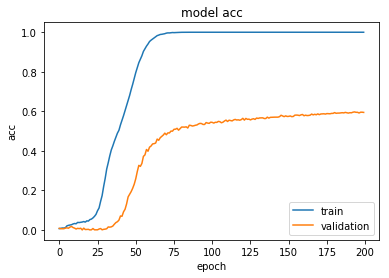
1 Hidden Layer of 200 nodes, relu activation
learning_rate = 0.3
training_epochs = 200
batch_size = 10
Trained on 80% randomly distributed possible datapoints
Tested/validated on remaining 20%
Observation : S-shaped convergence. Train accuracy reached 100% but validation reached only 59% 


# Ordered train dataset comprising entire input range
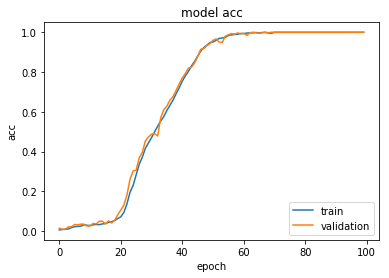
1 Hidden Layer of 200 nodes, relu activation
learning_rate = 0.3
training_epochs = 100
batch_size = 10
Trained on all possible datapoints arranged in order
Observation : S-shaped convergence; bigger batch size requires more epochs to reach same accuracy; tanh activation converges a lot slower


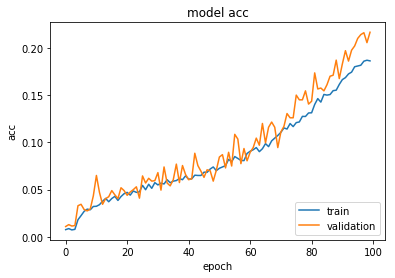
1 hidden layer with 100 nodes, tanh activation
learning_rate = 0.3
training_epochs = 50
batch_size = 10
Trained on all possible datapoints arranged in order
Low accuracy after 100 epochs; relu activation for hidden layer produced worse accuracy after 100 epochs

## 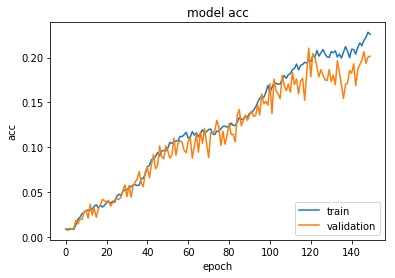
1 hidden layer with 50 nodes, relu activation
learning_rate = 0.3
training_epochs = 150
batch_size = 10
Trained on all possible datapoints arranged in order
Low accuracy after 150 epochs

In [22]:
model.save("Week1_Addition_MyWIP")

In [31]:
w = model.get_weights()

In [32]:
print(type(w), len(w))
for i in range(len(w)):
    print(type(w[i]), w[i].shape)


<class 'list'> 4
<class 'numpy.ndarray'> (200, 200)
<class 'numpy.ndarray'> (200,)
<class 'numpy.ndarray'> (200, 199)
<class 'numpy.ndarray'> (199,)


In [33]:
print(w[0][0,:])

[-0.62900299 -0.69123751  0.5536086  -0.4906531  -0.1311451  -0.74117482
 -0.04984578 -0.397899   -0.75077391 -0.21343242 -0.71741992  0.56837422
 -0.12290693 -0.53354365  0.75631595  0.5854429   1.66002595 -0.29482859
  0.37710133  0.18910253  0.36267006 -0.37839317 -0.65908647  0.73827022
 -0.03924908 -0.08563539  0.45356777  0.08030151 -0.24728888  0.79193497
  0.10930358  0.87602723  1.40035915 -0.56679577  0.01795793  0.87389004
  1.10090482 -0.221191   -0.93399161 -0.40224347  0.38707492 -0.25906104
  0.60287189 -0.85582072 -0.72859013 -0.36636886 -0.69069034 -0.25832212
 -0.45052043 -0.49770749  0.82238603 -0.49955124  0.0889134  -0.47314772
  0.46477255  0.90786076 -0.72238302  0.2484479  -0.41491669 -0.45492473
 -0.44916859  1.3606199   1.28524613 -0.26577562 -1.05692303 -0.31772259
  0.89002723  1.79829109 -0.24414843 -0.96140188 -0.38549769 -0.65626264
  0.52289706 -0.21760315 -0.48512039 -0.28887123  0.60154259 -0.89330941
 -0.65108079 -0.04892375  0.51629508 -0.19785385 -0